In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from datasets import load_dataset

# ----------------------------
# Custom activation: Global Circle Inversion per Channel
# ----------------------------
class CircleInversionGlobalPerChannel(nn.Module):
    """
    For an input tensor x of shape [B, C, H, W],
    treat each channel's HxW feature map as a vector and apply
    circle inversion with respect to the unit circle (R=1):
    
    x' = x / (||x||^2 + eps),
    
    where ||x||^2 is computed over the spatial dimensions for each channel.
    """
    def __init__(self, eps=1e-6):
        super(CircleInversionGlobalPerChannel, self).__init__()
        self.eps = eps

    def forward(self, x):
        # Compute the norm-squared over the spatial dimensions (H, W) per sample and channel.
        # x has shape [B, C, H, W] and we want norm_sq of shape [B, C, 1, 1].
        norm_sq = torch.sum(x ** 2, dim=(2, 3), keepdim=True)
        return x / (norm_sq + self.eps)

# ----------------------------
# Define a deep 20-layer CNN without extra nonlinearities (only using the chosen activation)
# Downsampling is performed with stride=2 convolutions.
# ----------------------------
class DeepCNN(nn.Module):
    def __init__(self, activation='relu'):
        """
        Constructs a CNN with 20 convolutional layers.
        The activation parameter determines the nonlinearity:
         - 'relu'   : uses nn.ReLU()
         - 'circle' : uses the custom CircleInversionGlobalPerChannel activation.
        """
        super(DeepCNN, self).__init__()
        if activation == 'relu':
            act_layer = nn.ReLU
        elif activation == 'circle':
            act_layer = CircleInversionGlobalPerChannel
        else:
            raise ValueError("Unsupported activation type. Use 'relu' or 'circle'.")

        layers = []
        # First convolution: from 3 input channels to 64 feature maps; downsample with stride=2.
        layers.append(nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1))
        layers.append(act_layer())
        # Add 19 more conv layers; every 5th layer downsamples (stride=2), the others use stride=1.
        for i in range(1, 20):
            stride = 2 if (i % 5 == 0) else 1
            layers.append(nn.Conv2d(64, 64, kernel_size=3, stride=stride, padding=1))
            layers.append(act_layer())
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, 1000)  # ImageNet has 1000 classes.
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ----------------------------
# Training and evaluation functions
# ----------------------------
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        inputs = batch['pixel_values'].to(device)
        targets = batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['pixel_values'].to(device)
            targets = batch['label'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)

def train_model(model, train_loader, val_loader, epochs, device, lr=0.001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss = validate(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    return train_losses, val_losses

# ----------------------------
# Main training script
# ----------------------------
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load a small subset of ImageNet via Hugging Face.
    # Note: The official ImageNet dataset may require credentials. Here we assume a dataset named "imagenet-1k".
    try:
        train_dataset = load_dataset("imagenet-1k", split="train[:1%]", token=True)
        val_dataset   = load_dataset("imagenet-1k", split="validation[:1%]", token=True)
    except Exception as e:
        print("Error loading ImageNet via Hugging Face:", e)
        return

    # Define transforms for training and validation.
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    transform_val = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    # A helper to apply the transforms.
    def transform_example(example, is_train=True):
        image = example["image"]
        image = transform_train(image) if is_train else transform_val(image)
        example["pixel_values"] = image
        return example

    train_dataset = train_dataset.map(lambda x: transform_example(x, is_train=True))
    val_dataset   = val_dataset.map(lambda x: transform_example(x, is_train=False))
    
    # Set the format for PyTorch tensors.
    train_dataset.set_format(type="torch", columns=["pixel_values", "label"])
    val_dataset.set_format(type="torch", columns=["pixel_values", "label"])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    epochs = 10  # Adjust epochs as needed.

    # --- Train with ReLU activation ---
    print("Training model with ReLU activation...")
    model_relu = DeepCNN(activation='relu')
    train_losses_relu, val_losses_relu = train_model(model_relu, train_loader, val_loader, epochs, device)

    # --- Train with Circle Inversion (global per channel) activation ---
    print("Training model with Circle Inversion activation (global per channel)...")
    model_circle = DeepCNN(activation='circle')
    train_losses_circle, val_losses_circle = train_model(model_circle, train_loader, val_loader, epochs, device)

    # ----------------------------
    # Plot and save the loss curves.
    # ----------------------------
    epochs_range = range(1, epochs + 1)

    # Plot Training Losses.
    plt.figure()
    plt.plot(epochs_range, train_losses_relu, label='ReLU Training Loss')
    plt.plot(epochs_range, train_losses_circle, label='Circle Inversion Training Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Training Loss Comparison")
    plt.legend()
    plt.savefig("training_loss.png")

    # Plot Validation Losses.
    plt.figure()
    plt.plot(epochs_range, val_losses_relu, label='ReLU Validation Loss')
    plt.plot(epochs_range, val_losses_circle, label='Circle Inversion Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.title("Validation Loss Comparison")
    plt.legend()
    plt.savefig("validation_loss.png")
    plt.show()

if __name__ == '__main__':
    main()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training for run 'gelu' with activation: gelu


Step,Training Loss,Validation Loss
200,7.091700,7.152304
400,6.802400,6.865454
600,6.625100,6.699932
800,6.372000,6.535298
1000,6.238800,6.447748
1200,6.211500,6.333847
1400,6.083600,6.275088
1600,6.097200,6.225603
1800,6.033300,6.179028
2000,6.050500,6.149959


Training complete for 'gelu'.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training for run 'circle' with activation: circle


Step,Training Loss,Validation Loss
200,7.298300,7.354194
400,6.957900,7.069866
600,6.827300,6.916944
800,6.601600,6.757446
1000,6.462800,6.660346
1200,6.456300,6.578868
1400,6.336000,6.516768
1600,6.360600,6.433412
1800,6.297100,6.407702
2000,6.309300,6.388587


Training complete for 'circle'.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training for run 'relu' with activation: relu


Step,Training Loss,Validation Loss
200,7.117300,7.195066
400,6.857200,6.944404
600,6.702100,6.775063
800,6.452600,6.625721
1000,6.314400,6.520072
1200,6.290800,6.404680
1400,6.165700,6.353760
1600,6.180100,6.275569
1800,6.115500,6.251420
2000,6.124100,6.226134


Training complete for 'relu'.


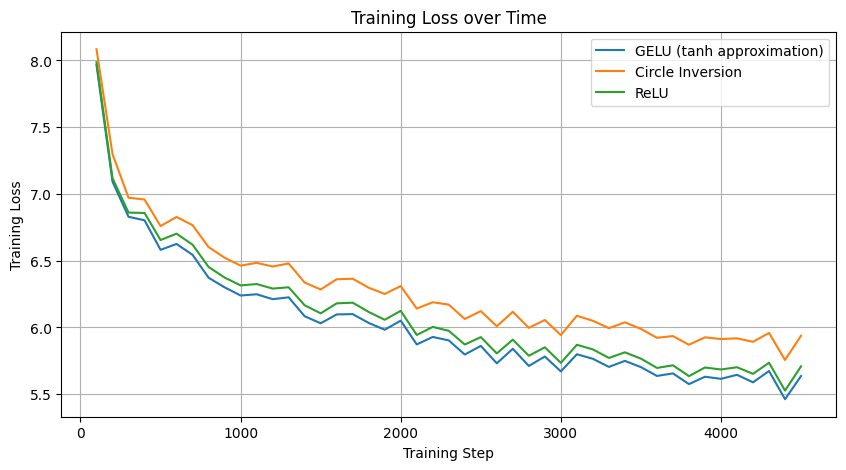

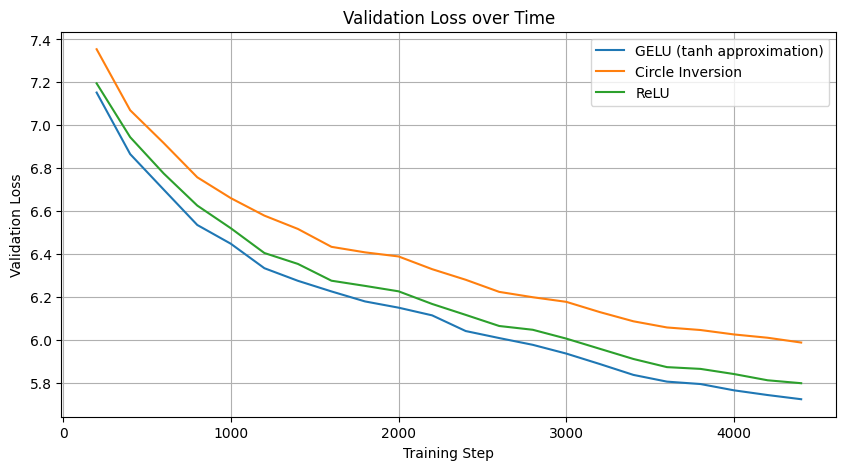

In [28]:
import torch
from transformers import GPT2Config, GPT2LMHeadModel, GPT2TokenizerFast, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from datasets import load_dataset
import transformers.models.gpt2.modeling_gpt2 as gpt2_modeling
import math
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define activation modules
class GELUActivation(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

class CircleInversionActivation(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
    def forward(self, x):
        norm_sq = torch.sum(x ** 2, dim=-1, keepdim=True)
        return x / (norm_sq + self.eps)

class VectorGELUActivation(nn.Module):
    """
    A vectorized activation inspired by GELU.
    For an input tensor v (of shape [..., hidden_dim]),
    it computes the L2 norm along the last dimension, r = ||v||,
    then outputs v * erf(r). For small r, erf(r) is small (close to zero),
    so the entire vector is nearly zeroed out; for large r, erf(r) is close to 1,
    so the output is close to v.
    """
    def forward(self, x):
        # Compute L2 norm along the last dimension; shape: same as x except last dim = 1.
        norm = torch.norm(x, p=2, dim=-1, keepdim=True)
        # Compute scaling factor using the error function.
        scale = torch.erf(norm)
        return x * scale
        
# We'll use nn.ReLU() for the ReLU activation.

# Helper function to override the activation in the model
def override_activation(model, activation="gelu"):
    for module in model.modules():
        if hasattr(module, "act"):
            if activation == "circle":
                module.act = CircleInversionActivation()
            elif activation == "relu":
                module.act = nn.ReLU()
            elif activation == "gelu":
                module.act = GELUActivation()
            else:
                raise ValueError("activation must be one of 'gelu', 'circle', or 'relu'.")

# Training function
def train_model(activation="gelu", run_name="gelu", logging_steps=100):
    # Create GPT-2 model with a small configuration
    config = GPT2Config(
        n_embd=256,       # hidden dimension
        n_layer=6,        # transformer layers
        n_head=4,         # attention heads
        vocab_size=50257, # standard GPT-2 vocab
    )
    model = GPT2LMHeadModel(config)
    
    # Override activation functions in the model's MLP layers
    override_activation(model, activation=activation)
    
    # Load tokenizer and set pad token
    tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token

    # Load WikiText-2 raw dataset (train split)
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
    
    # Tokenize dataset (truncate to max_length=128)
    def tokenize_function(examples):
        return tokenizer(examples["text"], truncation=True, max_length=128)
    tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
    
    # Set up training arguments
    training_args = TrainingArguments(
        output_dir=f"./gpt2_{run_name}",
        overwrite_output_dir=True,
        num_train_epochs=1,
        per_device_train_batch_size=8,
        evaluation_strategy="steps",
        eval_steps=200,
        logging_steps=logging_steps,
        save_steps=500,
        learning_rate=5e-4,
        weight_decay=0.01,
        report_to="none",
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset,
        eval_dataset=tokenized_dataset.select(range(100)),
        data_collator=data_collator,
    )
    
    print(f"Starting training for run '{run_name}' with activation: {activation}")
    trainer.train()
    print(f"Training complete for '{run_name}'.")
    return trainer.state.log_history

# Example: train with default GELU, circle inversion, and ReLU
log_history_gelu = train_model(activation="gelu", run_name="gelu")
log_history_circle = train_model(activation="circle", run_name="circle")
log_history_relu = train_model(activation="relu", run_name="relu")

# (Then extract and plot losses as before)
def extract_losses(log_history):
    train_steps, train_losses = [], []
    eval_steps, eval_losses = [], []
    for log in log_history:
        if "loss" in log:
            train_steps.append(log.get("step", log.get("epoch")))
            train_losses.append(log["loss"])
        if "eval_loss" in log:
            eval_steps.append(log.get("step", log.get("epoch")))
            eval_losses.append(log["eval_loss"])
    return (train_steps, train_losses), (eval_steps, eval_losses)

(train_steps_gelu, train_losses_gelu), (eval_steps_gelu, eval_losses_gelu) = extract_losses(log_history_gelu)
(train_steps_circle, train_losses_circle), (eval_steps_circle, eval_losses_circle) = extract_losses(log_history_circle)
(train_steps_relu, train_losses_relu), (eval_steps_relu, eval_losses_relu) = extract_losses(log_history_relu)

plt.figure(figsize=(10, 5))
plt.plot(train_steps_gelu, train_losses_gelu, label="GELU (tanh approximation)")
plt.plot(train_steps_circle, train_losses_circle, label="Circle Inversion")
plt.plot(train_steps_relu, train_losses_relu, label="ReLU")
plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.title("Training Loss over Time")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(eval_steps_gelu, eval_losses_gelu, label="GELU (tanh approximation)")
plt.plot(eval_steps_circle, eval_losses_circle, label="Circle Inversion")
plt.plot(eval_steps_relu, eval_losses_relu, label="ReLU")
plt.xlabel("Training Step")
plt.ylabel("Validation Loss")
plt.title("Validation Loss over Time")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import math
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from transformers import (
    GPT2Config,
    GPT2LMHeadModel,
    GPT2TokenizerFast,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
    TrainerCallback,
)
from datasets import load_dataset
import transformers.models.gpt2.modeling_gpt2 as gpt2_modeling

# ============================================================
# 1. Define activation modules as nn.Module wrappers.
# ============================================================

# (a) GELU activation (tanh approximation as used in GPT-2)
class GELUActivation(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

# (b) Trainable Erf Activation:
#      f(x) = x * erf(x / (sqrt(2)*sigma)) with sigma trainable.
class TrainableErfActivation(nn.Module):
    def __init__(self, init_sigma=1.0, eps=1e-6):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
        self.eps = eps
    def forward(self, x):
        denom = math.sqrt(2) * self.sigma + self.eps
        return x * torch.erf(x / denom)

# (c) Vector GELU Activation:
#      For each activation vector v, compute r = ||v|| and output v * erf(r/sqrt(2))
class VectorGELUActivation(nn.Module):
    def forward(self, x):
        norm = torch.norm(x, p=2, dim=-1, keepdim=True)
        scale = torch.erf(norm / math.sqrt(2))
        return x * scale

# (d) ReLU: use built-in module (nn.ReLU)

# ============================================================
# 2. Map activation names to factory functions.
# ============================================================
# We will only use these four:
activation_modules = {
    "trainable_erf": lambda: TrainableErfActivation(),
    "vecgelu": lambda: VectorGELUActivation(),
    "relu": lambda: nn.ReLU(),
    "gelu": lambda: GELUActivation(),
}

# ============================================================
# 3. Custom Callback to record additional metrics.
# ============================================================
class ActivationMetricsCallback(TrainerCallback):
    def __init__(self, grad_cutoff=1e-5, neuron_threshold=1e-3):
        super().__init__()
        self.grad_cutoff = grad_cutoff
        self.neuron_threshold = neuron_threshold
        self.metrics_log = {}  # global_step -> metrics dict
        self.activation_means = []        # from forward hooks
        self.dead_neuron_fractions = []     # from forward hooks
        self.gradients = {}  # to store gradients per parameter

    def on_train_begin(self, args, state, control, **kwargs):
        self.metrics_log = {}
        self.activation_means = []
        self.dead_neuron_fractions = []
        self.gradients = {}
        self.hooks = []
        self.param_hooks = []
        model = kwargs["model"]
        self.act_module_names = []
        # Register forward hooks on activation modules (attribute "act")
        for name, module in model.named_modules():
            if hasattr(module, "act") and isinstance(module.act, nn.Module):
                hook = module.act.register_forward_hook(self._forward_hook)
                self.hooks.append(hook)
                self.act_module_names.append(name + ".act")
        # Register parameter hooks to capture gradients.
        for name, param in model.named_parameters():
            if param.requires_grad:
                hook = param.register_hook(lambda grad, name=name: self._store_grad(name, grad))
                self.param_hooks.append(hook)
        print("Registered activation hooks on:", self.act_module_names)

    def _forward_hook(self, module, input, output):
        # output: tensor of shape [batch, seq_length, hidden_dim]
        self.activation_means.append(output.mean().item())
        neuron_mean_abs = output.abs().mean(dim=(0, 1))  # shape: [hidden_dim]
        dead_frac = (neuron_mean_abs < self.neuron_threshold).float().mean().item()
        self.dead_neuron_fractions.append(dead_frac)

    def _store_grad(self, name, grad):
        if name in self.gradients:
            self.gradients[name].append(grad.detach())
        else:
            self.gradients[name] = [grad.detach()]

    def on_backward_end(self, args, state, control, **kwargs):
        total_grad_elements = 0
        vanishing_grad_elements = 0
        total_grad_norm = 0.0
        for grad_list in self.gradients.values():
            grad = torch.stack(grad_list).mean(dim=0)
            total_grad_elements += grad.numel()
            vanishing_grad_elements += (grad.abs() < self.grad_cutoff).sum().item()
            total_grad_norm += grad.norm(2).item()
        grad_vanish_fraction = (vanishing_grad_elements / total_grad_elements) if total_grad_elements > 0 else 0.0
        self._grad_metrics = {"grad_vanish_fraction": grad_vanish_fraction, "grad_norm": total_grad_norm}

    def on_step_end(self, args, state, control, **kwargs):
        model = kwargs["model"]
        total_weight_elements = 0
        dead_weight_elements = 0
        total_weight_norm = 0.0
        for param in model.parameters():
            if param.requires_grad:
                weight = param.detach()
                total_weight_elements += weight.numel()
                dead_weight_elements += (weight.abs() < self.neuron_threshold).sum().item()
                total_weight_norm += weight.norm(2).item()
        dead_weight_fraction = (dead_weight_elements / total_weight_elements) if total_weight_elements > 0 else 0.0

        avg_activation = sum(self.activation_means)/len(self.activation_means) if self.activation_means else 0.0
        avg_dead_neuron_frac = sum(self.dead_neuron_fractions)/len(self.dead_neuron_fractions) if self.dead_neuron_fractions else 0.0

        grad_metrics = self._grad_metrics if hasattr(self, "_grad_metrics") else {"grad_vanish_fraction": 0.0, "grad_norm": 0.0}

        # If the model has any TrainableErfActivation, record its learned sigma.
        learned_sigma = None
        count = 0
        for module in model.modules():
            if isinstance(module, TrainableErfActivation):
                learned_sigma = module.sigma.item() if learned_sigma is None else learned_sigma + module.sigma.item()
                count += 1
        if count > 0:
            learned_sigma /= count

        step = state.global_step
        self.metrics_log[step] = {
            "grad_vanish_fraction": grad_metrics["grad_vanish_fraction"],
            "grad_norm": grad_metrics["grad_norm"],
            "dead_neuron_fraction": avg_dead_neuron_frac,
            "avg_activation": avg_activation,
            "weight_norm": total_weight_norm,
            "dead_weight_fraction": dead_weight_fraction,
            "learned_sigma": learned_sigma,
        }
        self.activation_means = []
        self.dead_neuron_fractions = []
        self.gradients = {}
        if hasattr(self, "_grad_metrics"):
            del self._grad_metrics

    def on_train_end(self, args, state, control, **kwargs):
        for hook in self.hooks:
            hook.remove()
        for hook in self.param_hooks:
            hook.remove()

# ============================================================
# 4. Helper function to override activations in the model.
# ============================================================
def override_activation(model, activation_name):
    if activation_name not in activation_modules:
        raise ValueError(f"Unsupported activation: {activation_name}")
    for module in model.modules():
        if hasattr(module, "act"):
            module.act = activation_modules[activation_name]()
    return model

# ============================================================
# 5. Training function.
# ============================================================
def train_model(activation_name="gelu", run_name="gelu", max_steps=10000, logging_steps=200):
    config = GPT2Config(
        n_embd=256,
        n_layer=6,
        n_head=4,
        vocab_size=50257,
    )
    model = GPT2LMHeadModel(config)
    override_activation(model, activation_name)
    tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token

    dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
    def tokenize_function(examples):
        return tokenizer(examples["text"], truncation=True, max_length=128)
    tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])
    tokenized_dataset = tokenized_dataset.filter(lambda x: len(x["input_ids"]) > 0)
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

    training_args = TrainingArguments(
        output_dir=f"./gpt2_{run_name}",
        overwrite_output_dir=True,
        max_steps=max_steps,
        per_device_train_batch_size=8,
        evaluation_strategy="steps",
        eval_steps=500,
        logging_steps=logging_steps,
        save_strategy="no",  # Do not save model weights
        learning_rate=5e-4,
        weight_decay=0.01,
        report_to="none",
    )

    metrics_callback = ActivationMetricsCallback()
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset,
        eval_dataset=tokenized_dataset.select(range(100)),
        data_collator=data_collator,
        callbacks=[metrics_callback],
    )

    print(f"Starting training for run '{run_name}' with activation: {activation_name}")
    trainer.train()
    print(f"Training complete for '{run_name}'.")
    return trainer.state.log_history, metrics_callback.metrics_log

# ============================================================
# 6. Run training experiments for selected activation variants.
# ============================================================
selected_activations = ["trainable_erf", "vecgelu", "relu", "gelu"]

log_histories = {}
metrics_logs = {}
for act_name in selected_activations:
    try:
        lh, ml = train_model(activation_name=act_name, run_name=act_name, max_steps=10000, logging_steps=200)
        log_histories[act_name] = lh
        metrics_logs[act_name] = ml
    except Exception as e:
        print(f"Error training with activation {act_name}: {e}")

# ============================================================
# 7. Helper function to extract loss curves.
# ============================================================
def extract_losses(log_history):
    train_steps, train_losses = [], []
    eval_steps, eval_losses = [], []
    for log in log_history:
        if "loss" in log:
            train_steps.append(log.get("step", log.get("epoch")))
            train_losses.append(log["loss"])
        if "eval_loss" in log:
            eval_steps.append(log.get("step", log.get("epoch")))
            eval_losses.append(log["eval_loss"])
    return (train_steps, train_losses), (eval_steps, eval_losses)

# ============================================================
# 8. Plot training and validation loss curves.
# ============================================================
plt.figure(figsize=(12, 6))
for act_name, log_history in log_histories.items():
    (train_steps, train_losses), _ = extract_losses(log_history)
    if train_steps and train_losses:
        plt.plot(train_steps, train_losses, label=act_name)
plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.title("Training Loss over Time for Selected Activations")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
for act_name, log_history in log_histories.items():
    _, (eval_steps, eval_losses) = extract_losses(log_history)
    if eval_steps and eval_losses:
        plt.plot(eval_steps, eval_losses, label=act_name)
plt.xlabel("Training Step")
plt.ylabel("Validation Loss")
plt.title("Validation Loss over Time for Selected Activations")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# 9. Plot the additional metrics.
# ============================================================
metric_names = ["grad_vanish_fraction", "dead_neuron_fraction", "avg_activation", "grad_norm", "weight_norm", "dead_weight_fraction", "learned_sigma"]

for metric in metric_names:
    plt.figure(figsize=(12, 6))
    for act_name, ml in metrics_logs.items():
        steps = sorted(ml.keys())
        values = [ml[s].get(metric, None) for s in steps if ml[s].get(metric, None) is not None]
        if steps and values:
            plt.plot(steps[:len(values)], values, label=act_name)
    plt.xlabel("Training Step")
    plt.ylabel(metric.replace("_", " ").title())
    plt.title(f"{metric.replace('_', ' ').title()} over Time")
    plt.legend()
    plt.grid(True)
    plt.show()
